# MOHAMMED_MAEEN3.py
# Turtle Games - Customer Loyalty and Segmentation Analysis



In [170]:
# 1. Import libraries
# ===============================
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
sns.set(color_codes=True)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maeenmohammed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ===============================
# 2. Load and prepare data
# ===============================

In [113]:
df = pd.read_csv('updat_review.csv')


In [114]:
# Display general info
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None
   gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18         12.30              39             210  graduate   
1    Male   23         12.30              81             524  graduate   
2  Female   22         13.12               6              40  graduate   
3  Female   25         13.12      

# ===============================
# 3. Data Cleaning and Selection
# ===============================

In [115]:
# Keep relevant columns only for NLP and analysis
df = df[['review', 'summary', 'remuneration',
         'spending_score', 'age', 'loyalty_points', 
         'gender', 'education']]
# Drop missing values in critical columns
df.dropna(subset=['review', 'summary'], inplace=True)

In [116]:
# Rename the column headers.
df = df.rename(columns={'remuneration (k£)': 'remuneration', 'spending_score (1-100)': 'spending_score'})
# View column names.
df['review'] = clean_text_column(df['review'])
df['summary'] = clean_text_column(df['summary'])
df.head()

,review,summary,remuneration,spending_score,age,loyalty_points,gender,education
0,when it comes to a dms screen the space on the...,the fact that 50 of this space is wasted on ar...,12.30,39,18,210,Male,graduate
1,an open letter to galeforce9\n\nyour unpainted...,another worthless dungeon masters screen from ...,12.30,81,23,524,Male,graduate
2,nice art nice printing why two panels are fil...,pretty but also pretty useless,13.12,6,22,40,Female,graduate
3,amazing buy bought it as a gift for our new dm...,five stars,13.12,77,25,562,Female,graduate
4,as my review of gf9s previous screens these we...,money trap,13.94,40,33,366,Female,graduate


In [117]:
# Convert review and summary columns to lowercase strings and strip punctuation
def clean_text_column(df_col):
    df_col = df_col.astype(str).str.lower()
    df_col = df_col.str.replace('[^\w\s]', '', regex=True)
    df_col = df_col.str.strip()
    return df_col


In [118]:
# Drop duplicates in review and summary
df.drop_duplicates(subset=['review', 'summary'], inplace=True)

In [119]:
# Encode gender: female=1, others=0
df['gender_encoded'] = df['gender'].astype(str).str.strip().str.lower().apply(lambda g: 1 if g == 'female' else 0)


In [120]:
# Clean and encode education levels
def encode_education(edu):
    edu = str(edu).strip().lower()
    if 'basic' in edu:
        return 1
    elif 'diploma' in edu:
        return 2
    elif 'graduate' in edu:
        return 3
    elif 'postgraduate' in edu:
        return 4
    elif 'phd' in edu:
        return 5
    else:
        return np.nan


In [121]:
df['education_encoded'] = df['education'].apply(encode_education)
df.dropna(subset=['education_encoded'], inplace=True)
df['education_encoded'] = df['education_encoded'].astype(int)

# ===============================
# 4. Linear Regression on Loyalty Points (Simple Linear Regression for Each Feature)
# ===============================

In [171]:

# Set your target
target = 'loyalty_points'
single_features = ['remuneration', 'spending_score', 'age']

for feat in single_features:
    print(f"\n--- Linear Regression for {feat} predicting {target} ---")
    
    # 1️⃣ Prepare feature and target
    X = df[[feat]].dropna()
    y = df.loc[X.index, target]

    # Add constant for statsmodels
    X_const = sm.add_constant(X)

    # 2️⃣ Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=19
    )

    # 3️⃣ Fit model using sklearn
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 4️⃣ Evaluate performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Intercept      : {model.intercept_:.4f}")
    print(f"Coefficient    : {model.coef_[0]:.4f}")
    print(f"Test RMSE      : {rmse:.2f}")
    print(f"Test R²        : {r2:.3f}")

    # 5️⃣ Statsmodels for standard error
    sm_model = sm.OLS(y, X_const).fit()
    print("Standard errors:", sm_model.bse.to_dict())

    # Optional: predict full set (for plotting if needed)
    # y_pred_full = model.predict(X)




--- Linear Regression for remuneration predicting loyalty_points ---
Intercept      : -59.2103
Coefficient    : 33.9352
Test RMSE      : 992.45
Test R²        : 0.396
Standard errors: {'const': 52.78654308792896, 'remuneration': 0.9898549152628017}

--- Linear Regression for spending_score predicting loyalty_points ---
Intercept      : -81.8644
Coefficient    : 33.1168
Test RMSE      : 949.12
Test R²        : 0.448
Standard errors: {'const': 46.40154046564413, 'spending_score': 0.8234054452817314}

--- Linear Regression for age predicting loyalty_points ---
Intercept      : 1752.6566
Coefficient    : -4.5636
Test RMSE      : 1278.92
Test R²        : -0.002
Standard errors: {'const': 88.9555492748095, 'age': 2.128488692357722}


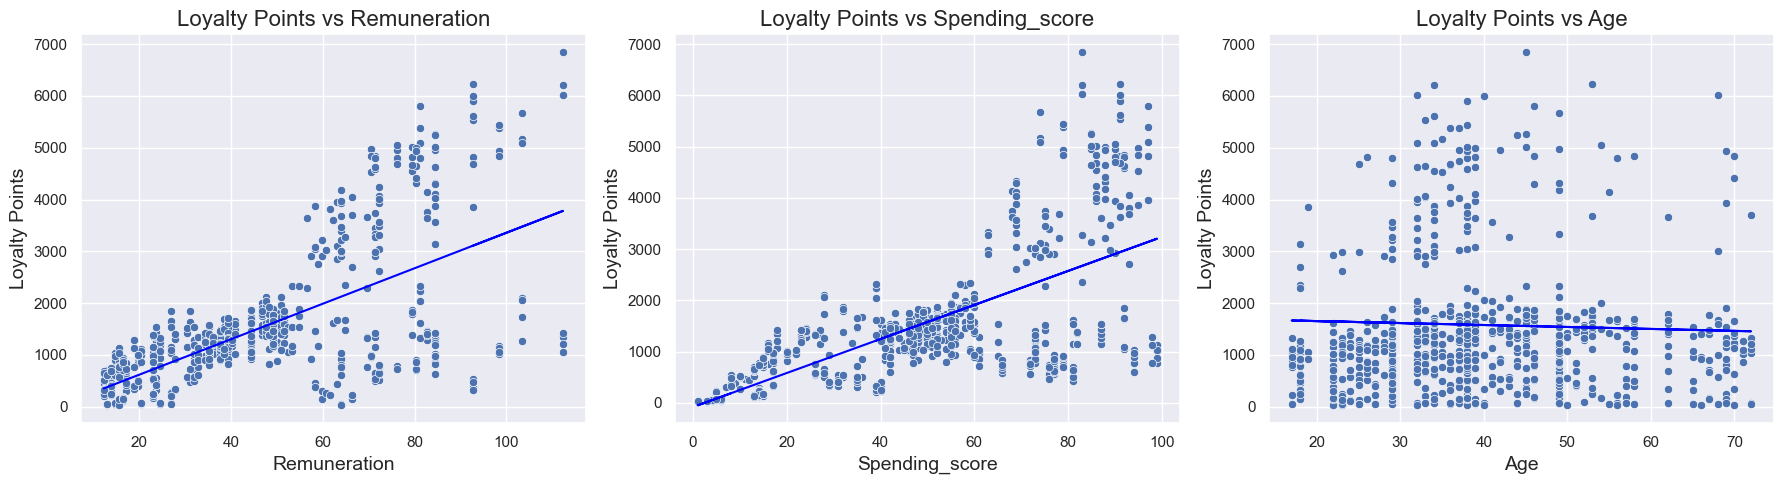

In [172]:
features = ['remuneration', 'spending_score', 'age']
fig, axes = plt.subplots(1, len(features), figsize=(18,5))

for i, feature in enumerate(features):
    X_feat = df[[feature]].dropna()
    y_feat = df.loc[X_feat.index, 'loyalty_points']
    lr = LinearRegression()
    lr.fit(X_feat, y_feat)

    sns.scatterplot(x=feature, y='loyalty_points', data=df, ax=axes[i])
    axes[i].plot(X_feat, lr.predict(X_feat), color='blue')
    axes[i].set_title(f'Loyalty Points vs {feature.capitalize()}', fontsize=16)
    axes[i].set_xlabel(feature.capitalize(), fontsize=14)
    axes[i].set_ylabel('Loyalty Points', fontsize=14)

plt.tight_layout()
plt.savefig('linear_regression_all_features.png')
plt.show()


## Summary and Recommendations:

To understand which customer attributes most influence loyalty, separate linear regression models were fitted for **remuneration**, **spending score**, and **age** as predictors of loyalty points. The models were trained and tested using an 80/20 split, and evaluated using RMSE and R².

The results show that both **remuneration** and **spending score** have a strong positive impact on loyalty, with coefficients of approximately **33.9** and **33.1**, and R² values of **0.396** and **0.448** respectively. This suggests that customers with higher incomes and more frequent spending tend to accumulate more loyalty points. 

In contrast, **age** showed a very weak and slightly negative relationship with loyalty points (R² ≈ 0), suggesting that age is not a significant predictor in this context.

These insights directly support Turtle Games’ business goal of targeting high-value customers by reinforcing the importance of income and spending behavior in loyalty-driven marketing strategies.



# ===============================
# 5 Decision Tree Regression
# ===============================

In [188]:
X = df[features].dropna()
y = df.loc[X.index, 'loyalty_points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)


In [189]:
dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=5)
dt_regressor.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [175]:
y_pred = dt_regressor.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Decision Tree RMSE on Test set: {dt_rmse:.2f}")


Decision Tree RMSE on Test set: 115.80


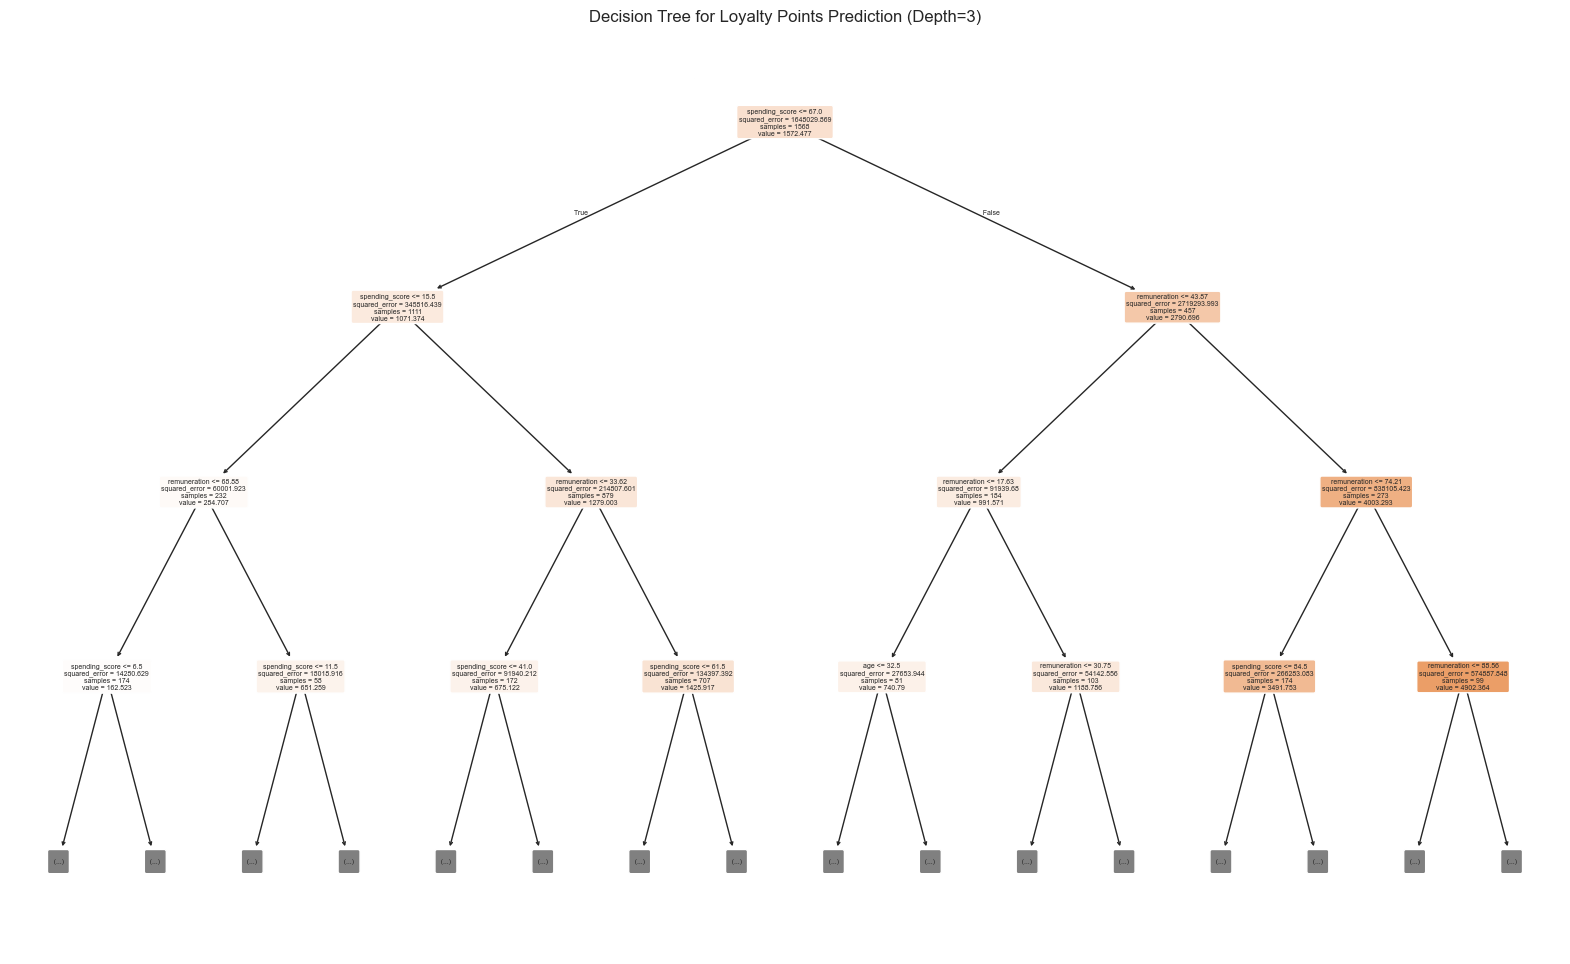

In [176]:
# Optional: Plot decision tree (limited depth for readability)
plt.figure(figsize=(20,12))
plot_tree(dt_regressor, feature_names=features, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree for Loyalty Points Prediction (Depth=3)")
plt.savefig("decision_tree.png")
plt.show()

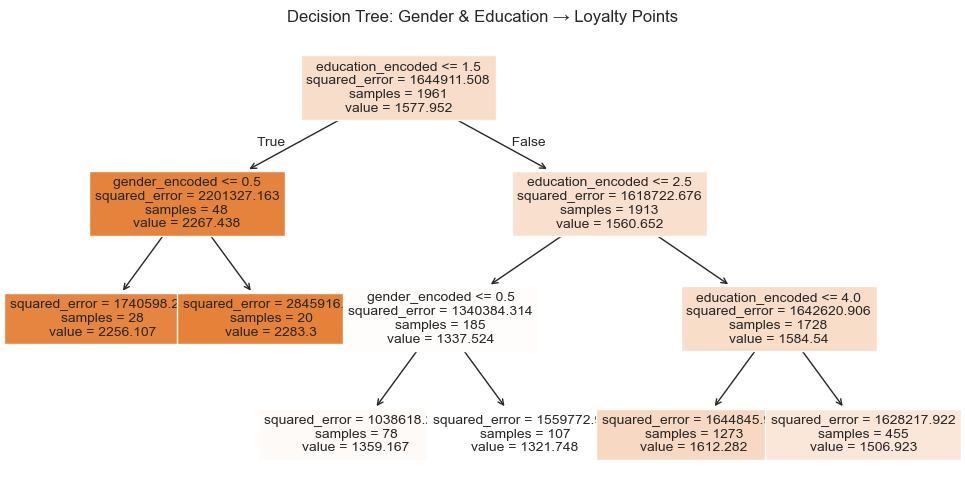

In [126]:
features_demo = ['gender_encoded', 'education_encoded']
X_demo = df[features_demo]
y_demo = df['loyalty_points']

tree_demo = DecisionTreeRegressor(max_depth=3, random_state=0)
tree_demo.fit(X_demo, y_demo)

# Plot it
plt.figure(figsize=(12, 6))
plot_tree(tree_demo, feature_names=features_demo, filled=True, fontsize=10)
plt.title("Decision Tree: Gender & Education → Loyalty Points")
plt.savefig('decision_edu.png')
plt.show()

##  Decision Tree Summary

The first decision tree model segmented customers using **spending score** and **remuneration** to predict loyalty points. The tree revealed that **spending score** was the most important factor in explaining loyalty behavior, with distinct splits that helped identify high- and low-value customer segments. This can support Turtle Games in tailoring its marketing strategies based on spending behavior.

To explore whether demographic features also influence loyalty, a second decision tree was built using education level and gender. This model showed that customers with **lower education levels** tend to earn more loyalty points on average, while gender had a relatively minor effect. Although these features were less predictive than financial attributes, they still offer valuable insights for refining customer segmentation.

Overall, combining both models enables Turtle Games to gain a deeper understanding of loyalty drivers from multiple angles—**behavioral (spending/income)** and **demographic (gender/education)**—and apply this understanding to develop more effective, personalized engagement strategies.
.




## ===============================
# 6. K-Means Clustering for Customer Segmentation
# ===============================


In [183]:
# Select features and scale
kmeans_features = ['remuneration', 'spending_score']
X_kmeans = df[kmeans_features].dropna()
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_kmeans), columns=kmeans_features)

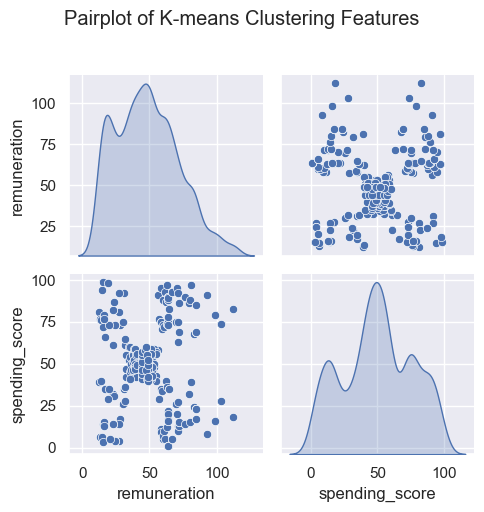

In [187]:
sns.pairplot(data=df, vars=kmeans_features, diag_kind='kde')
plt.suptitle("Pairplot of K-means Clustering Features", y=1.02)
plt.tight_layout()
plt.savefig('pairplot_kmeans_features.png')
plt.show()

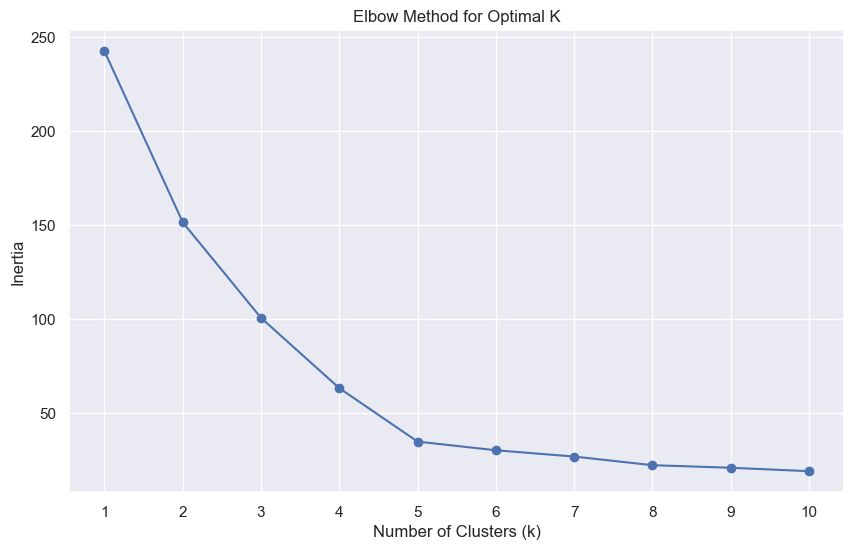

In [184]:
# Plot the elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.savefig("elbow_method.png")
plt.show()

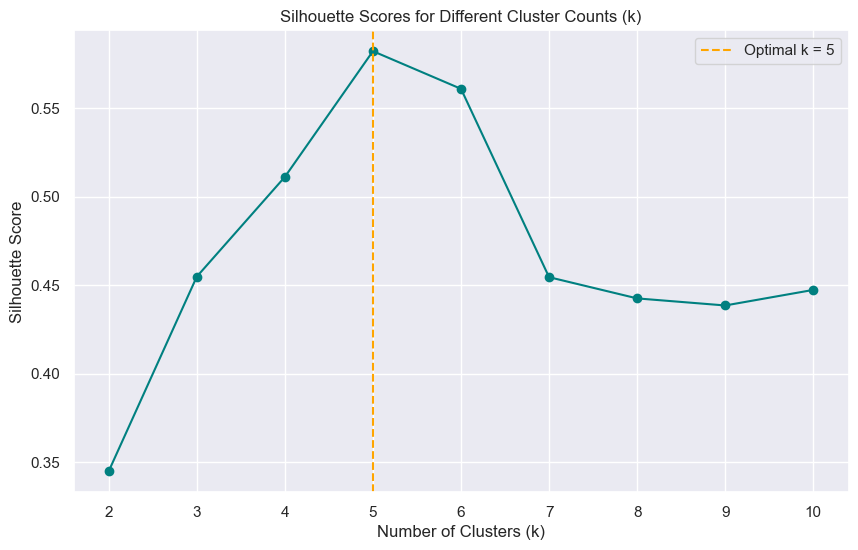

In [185]:
# Range of k values and the silhouette scores you've computed
K_range = range(2, 11)
silhouette_scores = [0.3448, 0.4548, 0.5112, 0.5823, 0.5610, 0.4545, 0.4425, 0.4385, 0.4473]

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.title("Silhouette Scores for Different Cluster Counts (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)

# Highlight the optimal point
optimal_k = 5
plt.axvline(optimal_k, color='orange', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.legend()

# Save the figure
plt.savefig("silhouette_scores.png")
plt.show()


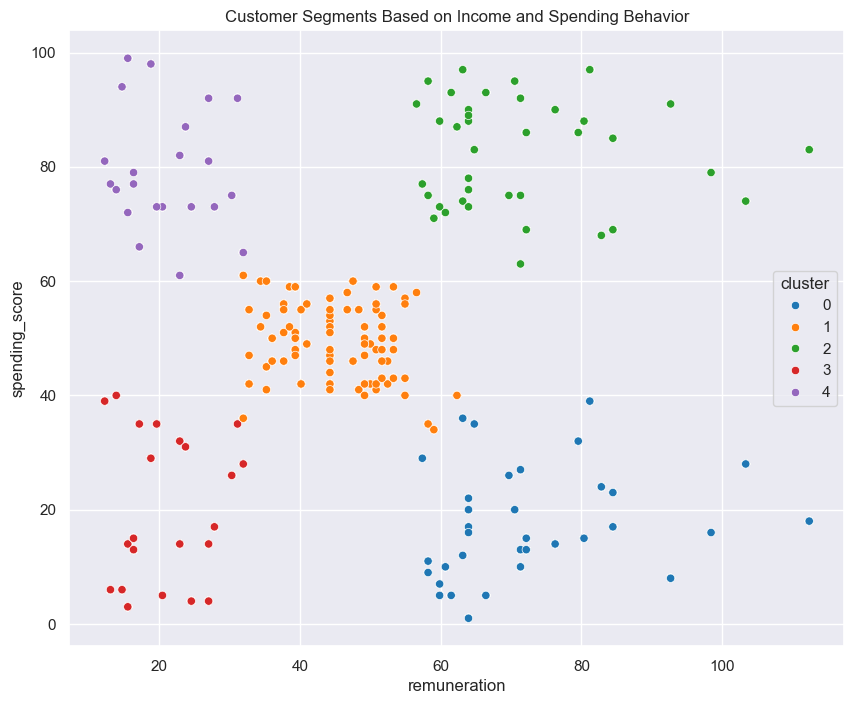

In [182]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='remuneration', y='spending_score', hue='cluster', data=df, palette='tab10')
plt.title('Customer Segments Based on Income and Spending Behavior')
plt.savefig('clusters.png')
plt.show()

## Summary and Recommendation

The five clusters represent distinct customer profiles based on remuneration and spending behavior. This segmentation empowers the marketing team to tailor strategies to each group’s unique needs, improving engagement and maximizing campaign ROI.
Recommendation:
 Leverage these customer segments to design personalized marketing and loyalty campaigns. By targeting each group with relevant messaging and offers, Turtle Games can increase customer retention, boost spending, and enhance overall sales performance.

# ===============================
# 7. NLP: Tokenization, Wordcloud, Frequency & Sentiment
# ===============================


In [143]:
# Tokenize review and summary columns
df['review_tokens'] = df['review'].apply(word_tokenize)
df['summary_tokens'] = df['summary'].apply(word_tokenize)


In [144]:
# Flatten tokens for all reviews and summaries
all_reviews_text = ' '.join(word for tokens in df['review_tokens'] for word in tokens)
all_summaries_text = ' '.join(word for tokens in df['summary_tokens'] for word in tokens)


In [166]:
# Remove stopwords
all_reviews_filtered = [word for word in all_reviews_text.split() if word not in stop_words]
all_summaries_filtered = [word for word in all_summaries_text.split() if word not in stop_words]


In [167]:
# Modular function for wordcloud plotting
def plot_wordcloud(words_list, title, filename):
    wc = WordCloud(
        width=1600,
        height=900,
        background_color='white',
        colormap='plasma',
        min_font_size=10
    ).generate(' '.join(words_list))
    
    plt.figure(figsize=(15,9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.savefig(filename)
    plt.show()


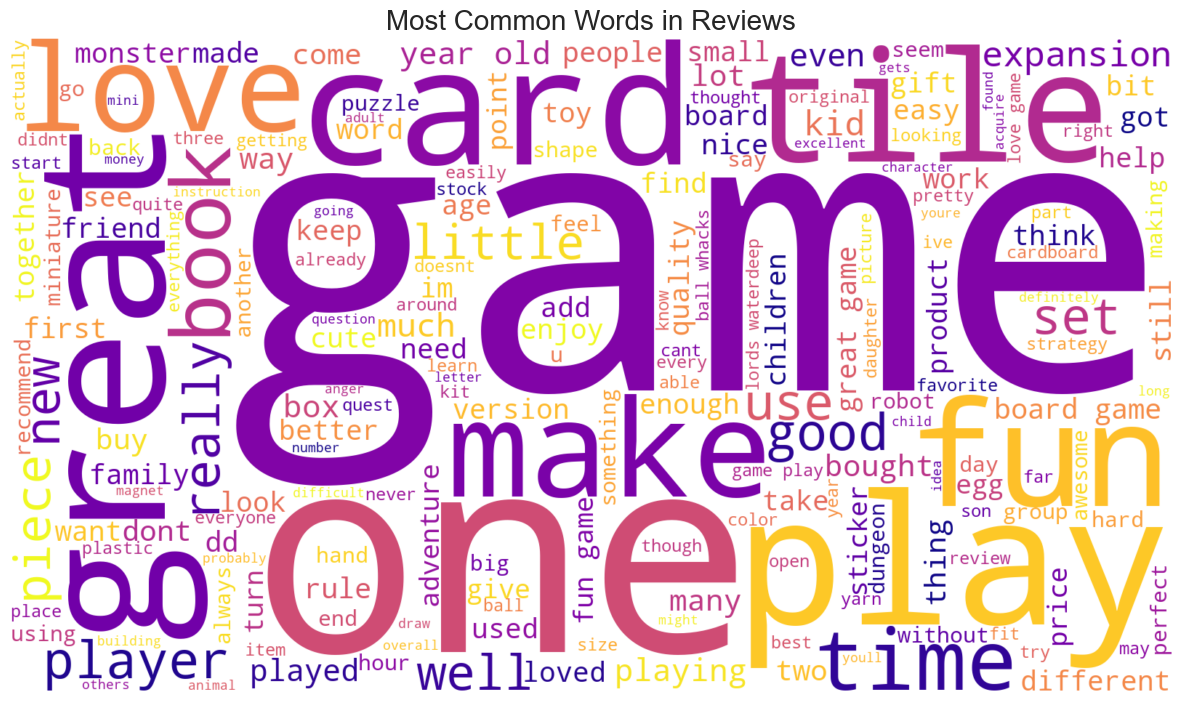

In [150]:
# Generate wordclouds
plot_wordcloud(all_reviews_filtered, 'Most Common Words in Reviews', 'review_wordcloud.png')


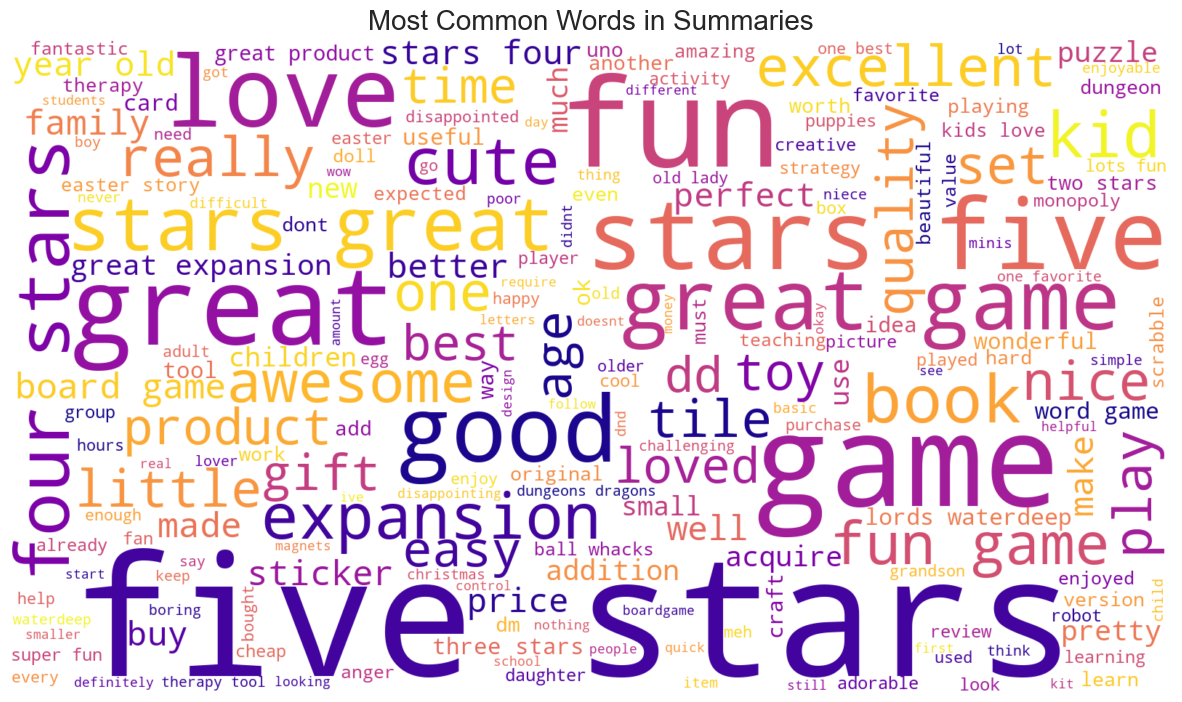

In [151]:
plot_wordcloud(all_summaries_filtered, 'Most Common Words in Summaries', 'summary_wordcloud.png')

In [152]:
# Frequency distributions of words
freq_review = FreqDist(all_reviews_filtered)
freq_summary = FreqDist(all_summaries_filtered)

In [153]:
print("Top 15 words in reviews:\n", freq_review.most_common(15))
print("Top 15 words in summaries:\n", freq_summary.most_common(15))

Top 15 words in reviews:
 [('game', 1671), ('great', 580), ('fun', 552), ('one', 530), ('play', 502), ('like', 414), ('love', 323), ('really', 319), ('get', 319), ('cards', 301), ('tiles', 297), ('time', 291), ('good', 289), ('would', 280), ('book', 273)]
Top 15 words in summaries:
 [('stars', 427), ('five', 342), ('game', 319), ('great', 295), ('fun', 218), ('love', 93), ('good', 92), ('four', 58), ('like', 54), ('expansion', 52), ('kids', 50), ('cute', 45), ('book', 43), ('one', 38), ('awesome', 36)]


In [154]:
# Polarity function
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


In [155]:
# Calculate polarity for review and summary
df['review_polarity'] = df['review'].apply(get_polarity)
df['summary_polarity'] = df['summary'].apply(get_polarity)


In [156]:
# Modular function for polarity histogram
def plot_polarity_hist(data, column, title, filename):
    plt.figure(figsize=(10,6))
    sns.histplot(data[column], bins=15, kde=True, color='steelblue')
    plt.title(title)
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.show()


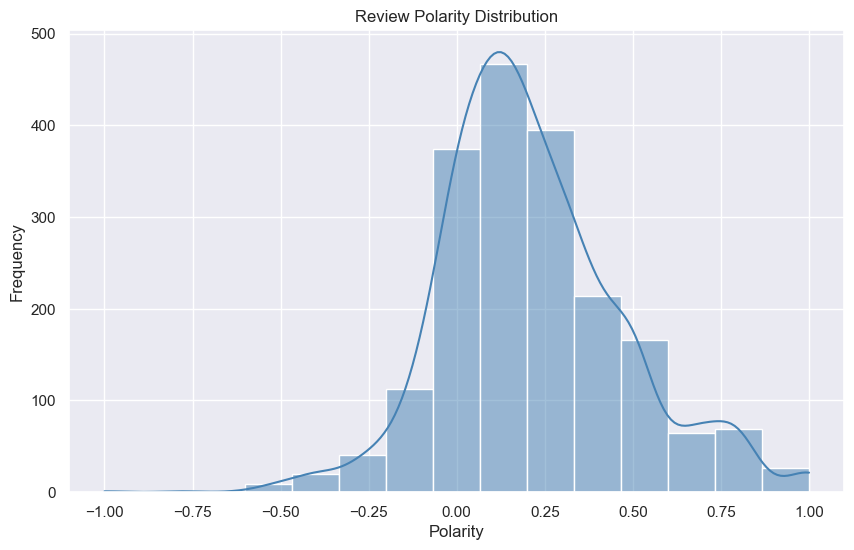

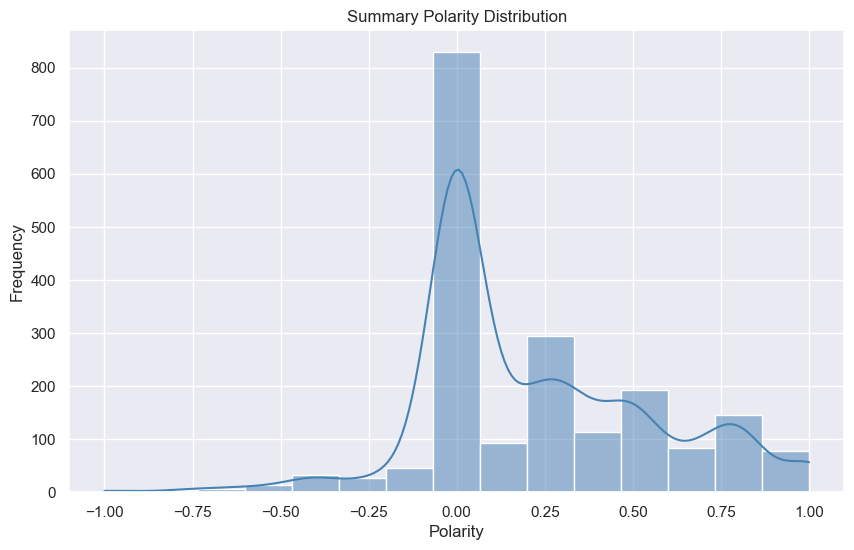

In [157]:
plot_polarity_hist(df, 'review_polarity', 'Review Polarity Distribution', 'review_polarity_hist.png')
plot_polarity_hist(df, 'summary_polarity', 'Summary Polarity Distribution', 'summary_polarity_hist.png')



In [158]:
# Print top 20 positive and negative reviews
print("Top 20 positive reviews:")
print(df.nlargest(20, 'review_polarity')[['review', 'review_polarity']])
print("\nTop 20 negative reviews:")
print(df.nsmallest(20, 'review_polarity')[['review', 'review_polarity']])
print("\nTop 20 positive summaries:")


Top 20 positive reviews:
                                                 review  review_polarity
7                             came in perfect condition              1.0
165                                        awesome book              1.0
194                                        awesome gift              1.0
496   excellent activity for teaching selfmanagement...              1.0
524                         perfect just what i ordered              1.0
591                                   wonderful product              1.0
609                                  delightful product              1.0
621   wonderful for my grandson to learn the resurre...              1.0
790                                             perfect              1.0
933                                             awesome              1.0
1135                                        awesome set              1.0
1168               best set buy 2 if you have the means              1.0
1177               awesome

In [159]:
# Print top 20 positive and negative summaries
print("\nTop 20 positive summaries:")
print(df.nlargest(20, 'summary_polarity')[['summary', 'summary_polarity']])

print("\nTop 20 negative summaries:")
print(df.nsmallest(20, 'summary_polarity')[['summary', 'summary_polarity']])



Top 20 positive summaries:
                                               summary  summary_polarity
6                                  best gm screen ever               1.0
28                                   wonderful designs               1.0
32                                             perfect               1.0
80   theyre the perfect size to keep in the car or ...               1.0
134                            perfect for preschooler               1.0
140             awesome sticker activity for the price               1.0
161                                       awesome book               1.0
163                    he was very happy with his gift               1.0
187                                            awesome               1.0
210           awesome and welldesigned for 9 year olds               1.0
418                                            perfect               1.0
475                                          excellent               1.0
543                    

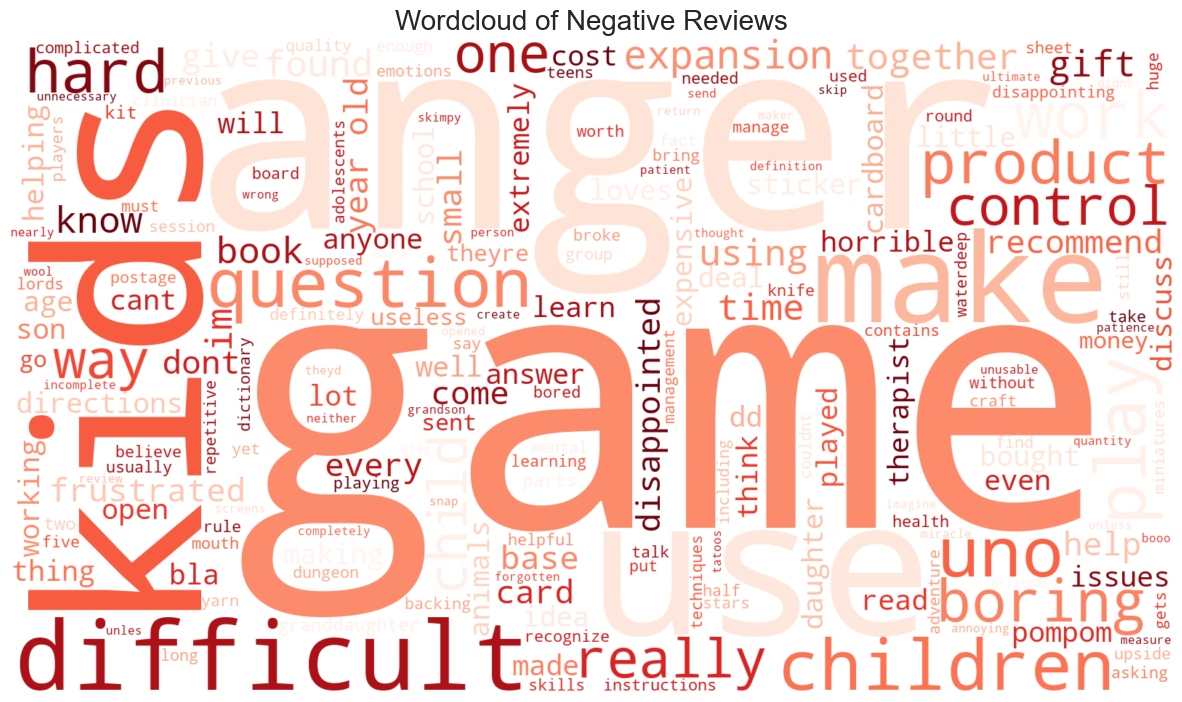

In [160]:

import re

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

# Apply cleaning
df['review'] = df['review'].apply(clean_text)

# Calculate sentiment polarity
df['review_polarity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Filter reviews with strong negative sentiment
negative_reviews = df[df['review_polarity'] < -0.2]['review']

# Combine all text into one string
negative_text = ' '.join(negative_reviews)

# Optionally exclude common positive words that sneak into mixed reviews
positive_words = ['fun', 'great', 'love', 'enjoy', 'awesome', 'fantastic', 'like']
filtered_negative_words = ' '.join([word for word in negative_text.split() if word not in positive_words])

# Generate and display the wordcloud
wordcloud = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Reds',
    min_font_size=10
).generate(filtered_negative_words)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Negative Reviews', fontsize=20)
plt.savefig('negative_review_wordcloud_cleaned.png')
plt.show()



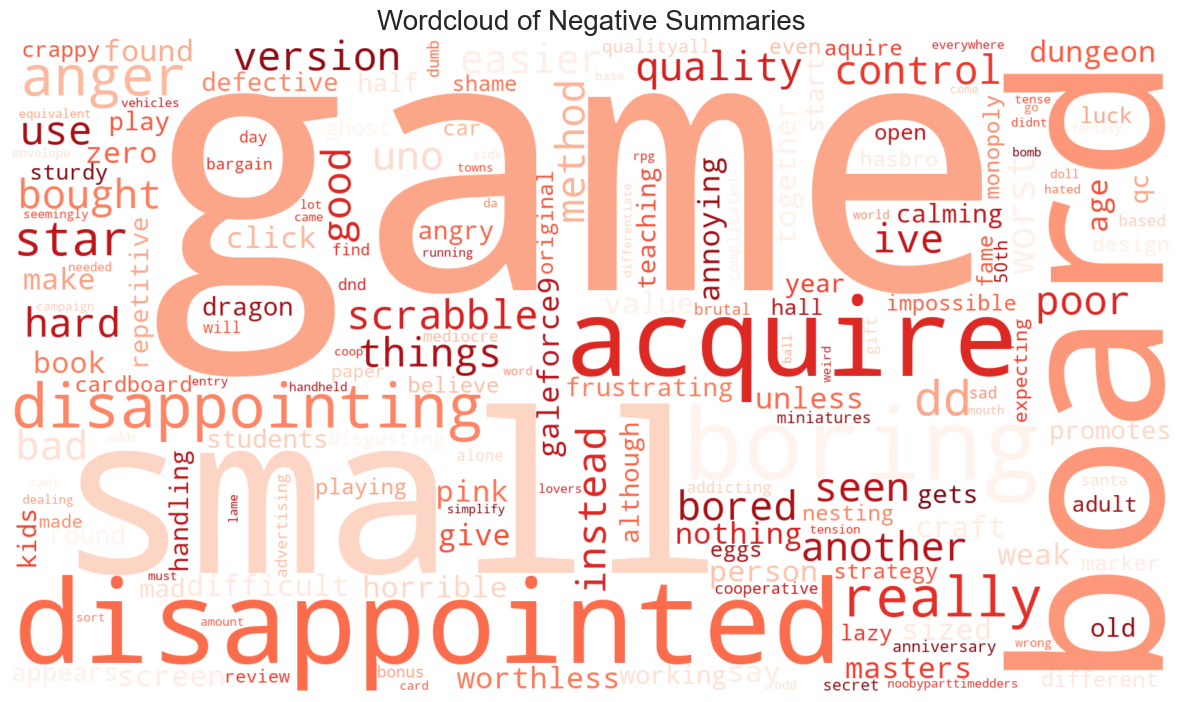

In [161]:
# Generate wordcloud for negative summaries
negative_summaries = df[df['summary_polarity'] < -0.2]['summary']
negative_summary_text = ' '.join(negative_summaries)

filtered_negative_summary = ' '.join([word for word in negative_summary_text.split() if word not in positive_words])

wordcloud_sum = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Reds',
    min_font_size=10
).generate(filtered_negative_summary)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud_sum, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Negative Summaries', fontsize=20)
plt.savefig('negative_summary_wordcloud_cleaned.png')
plt.show()

## Summary:
The sentiment analysis of Turtle Games customer reviews and summaries reveals an overall positive customer experience. The most common words in both reviews and summaries—such as "game," "fun," "great," "love," and "stars"—indicate high engagement and satisfaction with the products. The top positive reviews reinforce this sentiment, highlighting satisfaction with product quality, timely delivery, and overall enjoyment. Conversely, the top negative reviews focus on challenges like product complexity, incomplete kits, and pricing concerns, reflecting areas where customers faced difficulties or were dissatisfied.

Polarity histograms show that most feedback skews positive, though a notable portion of negative sentiment exists, warranting attention. The word clouds visually affirm that positive expressions dominate, but critical issues like setup complexity and price sensitivity are evident in negative feedback.

## Recommendation:
To capitalize on strengths, the marketing team should highlight features that customers praise, such as fun gameplay and product quality. For product improvement, efforts should focus on simplifying instructions, enhancing kit completeness, and reviewing pricing strategies to address concerns. Additionally, deploying targeted customer support and educational content could mitigate confusion. Incorporating these insights will help Turtle Games refine its offerings and enhance customer satisfaction and loyalty.

